## ForrestMapping
-----


Forest species mapping supported with machine learning.

In [1]:
!pip3 -q install seaborn
!pip3 -q install cartopy
!pip3 -q install verde
!pip3 -q install wget
!pip3 -q install contextily
!pip3 -q install xgboost
!pip -q install imbalanced-learn

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio 
from rasterio.mask import mask as crop_mask
import os, wget
from collections import Counter
import numpy as np
import verde as vd
from shapely.geometry import box
from imblearn.under_sampling import RandomUnderSampler 
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer

from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
# from xgboost import XGBClassifier

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
import warnings
warnings.filterwarnings('ignore')

## 1. Read GeoJSON dataset

In [18]:
def get_dataset(gdf: gpd.GeoDataFrame, non_forest:gpd.GeoDataFrame, threshold: float=80):
    rename = {"SOS_PRC": "С",
            "OS_PRC": "ОС",
            "BER_PRC": "Б",
            "PICH_PRC": "П",
            "EL_PRC": "Е",
            "KEDR_PRC": "К",
            "LSTV_PRC": "Л"}

    code_class = {'С': 7,
           'ОС': 5,
           'Б': 1,
           'П': 6,
           'Е': 2,
           'К': 3,
           'Л': 4}
    
    target_cols = ['EL_PRC', 'KEDR_PRC', 'LSTV_PRC','PICH_PRC', 'SOS_PRC', 'BER_PRC', 'OS_PRC']

    mask = gdf[target_cols]>threshold
    select=gdf.loc[mask.any(axis=1)].copy()
    t = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, 't'] = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, 't_Клас'] = select['t'].apply(lambda x : rename[x])
    select.loc[:, 't_Class'] = select['t_Клас'].apply(lambda x : code_class[x])
    select.pop('t')
    non_forest[select.columns[:-3]] = 1
    select = pd.concat([select, non_forest[select.columns]])
    return select

In [86]:
# dataset with ~280 points with threshold > 80 %
# small_dataset = "../shape_data/dataset_plots.geojson"
# full dataset with ~800
full_dataset = "../shape_data/forest.geojson"
gdf = gpd.read_file(full_dataset)
non_forest=gpd.read_file('../shape_data/non_forest.geojson')

# threshold=80 -> Percent of main forest type for inventory plot
gdf = get_dataset(gdf=gdf, non_forest=non_forest, threshold=50)
gdf = gdf.reset_index(drop=True)
gdf.loc[:, 'key'] = gdf.index


## 2. Download and read tiff file

In [87]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/home/notebooks/utils.py'>

In [88]:
dataset = utils.Dataset()
dataset.download_dataset()

gdf=dataset.procces_gdf(gdf)
bands, terrain = dataset.get_dataset(gdf=gdf, scale=2.0)

file downloaded
Radius of forest plot: 17.95
Start preparing bands  -- Done ✅
Start preparing terrain
 -- Done ✅


In [89]:
# S2 L2A bands and SVI 
bands.head()


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,NDVI,EVI,MSAVI,NDRE,key,class
1,0.11395,0.08485,0.06990,0.04455,0.07095,0.1674,0.19695,0.18960,0.21530,0.0654,0.0938,0.03880,0.619475,0.279691,0.258963,0.455383,0,7
2,0.11395,0.08560,0.07040,0.04560,0.07095,0.1674,0.19695,0.18175,0.21530,0.0654,0.0938,0.03880,0.598856,0.263613,0.243021,0.438465,0,7
4,0.11395,0.08485,0.07075,0.04435,0.07000,0.1663,0.19625,0.18515,0.21195,0.0654,0.0916,0.03775,0.613508,0.272532,0.251756,0.451303,0,7
5,0.11395,0.08560,0.07405,0.04650,0.07095,0.1674,0.19695,0.19480,0.21530,0.0654,0.0938,0.03880,0.614588,0.283795,0.263352,0.466040,0,7
6,0.11395,0.08670,0.07445,0.04805,0.07095,0.1674,0.19695,0.20295,0.21530,0.0654,0.0938,0.03880,0.617131,0.293756,0.273603,0.481928,0,7


In [90]:
# Fill diagonal and upper half with NaNs
corr = bands.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.iloc[:, :]
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,NDVI,EVI,MSAVI,NDRE
B01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B02,0.96,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B03,0.87,0.94,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B04,0.81,0.90,0.94,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B05,0.72,0.82,0.94,0.94,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B06,0.21,0.30,0.56,0.47,0.66,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B07,0.14,0.22,0.48,0.38,0.58,0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B08,0.15,0.23,0.50,0.41,0.60,0.99,0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan
B8A,0.18,0.26,0.52,0.44,0.63,0.99,0.99,0.99,nan,nan,nan,nan,nan,nan,nan,nan
B09,0.10,0.22,0.50,0.46,0.67,0.92,0.90,0.90,0.91,nan,nan,nan,nan,nan,nan,nan


## 3. Train ML models

In [91]:
from utils import scale_normalize, get_models, get_metric
from utils import decodeClasses, decodeClassesLevel1

In [92]:
def get_models(class_weights: dict) -> list:
    n_jobs = 8
    return [
        KNeighborsClassifier(
            n_jobs=n_jobs,
            algorithm="ball_tree",
            leaf_size=100,
            n_neighbors=10,
            weights="uniform",
        ),
        DecisionTreeClassifier(
            random_state=42,
            criterion="entropy",
            max_depth=9,
            max_features=None,
            min_samples_leaf=3,
            min_samples_split=2,
            splitter="best",
            class_weight=class_weights,
        ),
        RandomForestClassifier(
            n_jobs=n_jobs,
            random_state=42,
            criterion="gini",
            max_features="auto",
            class_weight=class_weights,
            max_depth=50,
            n_estimators=500,
            min_samples_leaf=2,
            min_samples_split=6,
        ),
        ExtraTreesClassifier(
            n_jobs=n_jobs,
            random_state=42,
            class_weight=class_weights,
            criterion="entropy",
            max_depth=9,
            max_features="log2",
            min_samples_leaf=5,
            min_samples_split=2,
            n_estimators=150,
        ),
#         RidgeClassifier(
#             random_state=42,
#             solver="sag",
#             class_weight=class_weights,
#             fit_intercept=True,
#             alpha=1.1,
#             tol=1e-5,
#         ),
        LogisticRegression(
            n_jobs=n_jobs,
            random_state=42,
            class_weight=class_weights,
            dual=False,
            fit_intercept=False,
            C=1.2,
            max_iter=100,
            tol=1e-04,
            penalty="l1",
            solver="saga",
        ),
        SVC(
            random_state=42,
            gamma="scale",
            class_weight=class_weights,
            kernel="poly",
            C=1,
            degree=1,
            tol=1e-5,
            probability=True,
        ),
        GradientBoostingClassifier(
            **{
                "n_estimators": 75,
                "min_samples_split": 47,
                "max_leaf_nodes": 52,
                "learning_rate": 0.1202,
            }
        )
        #                    XGBClassifier(n_jobs=-1, tree_method='gpu_hist', predictor='gpu_predictor', booster='gblinear', eta=0.3, gamma='auto', max_depth=20)
    ]


def get_metric(base_classfiers: list, y_test: np.ndarray, X_test: np.ndarray):
    score_classfiers_accuracy_score = []
    score_classfiers_roc_auc_score = []
    score_classfiers_f1_score = []
    df_score_class_dict = {}
    df_score_class_list = []

    name_classifiers = [
        "KNeighborsClassifier",
        "DecisionTreeClassifier",
        "RandomForest",
        "ExtraTreesClassifier",
#         "RidgeClassifier",
        "LogisticRegression",
        "SVC",
        "GradientBoostingClassifier",
    ]
    for i in range(len(base_classfiers)):
        y_predict = base_classfiers[i].predict(X_test)
        score_classfiers_accuracy_score.append(accuracy_score(y_test, y_predict))
        if name_classifiers[i] != "RidgeClassifier":
            score_classfiers_roc_auc_score.append(
                roc_auc_score(
                    y_test, base_classfiers[i].predict_proba(X_test), multi_class="ovr"
                )
            )
        else:
            ridge_predict = []
            for k in range(len(X_test)):
                d = base_classfiers[i].decision_function(X_test)[k]
                probs = np.exp(d) / np.sum(np.exp(d))
                ridge_predict.append(probs)
            ridge_predict = np.array(ridge_predict)
            score_classfiers_roc_auc_score.append(
                roc_auc_score(y_test, ridge_predict, multi_class="ovr")
            )

        score_classfiers_f1_score.append(
            f1_score(y_test, y_predict, average="weighted")
        )
        df_i = pd.DataFrame(
            metrics.classification_report(y_test, y_predict, digits=2, output_dict=True)
        ).transpose()
        arrays_col = [
            [
                name_classifiers[i],
                name_classifiers[i],
                name_classifiers[i],
                name_classifiers[i],
            ],
            list(df_i.columns),
        ]
        df_i.columns = pd.MultiIndex.from_tuples(list(zip(*arrays_col)))
        df_score_class_list.append(df_i)
        df_score_class_dict[name_classifiers[i]] = df_i

    df_score_class = df_score_class_list[0]
    for i in range(1, len(df_score_class_list)):
        df_score_class = df_score_class.join(df_score_class_list[i])
    df_score_class_index = list(df_score_class.index)

    df_score_group = pd.DataFrame(
        columns=["Model", "Accuracy score", "ROC AUC score", "f1 score"]
    )
    df_score_group["Model"] = name_classifiers
    df_score_group["Accuracy score"] = score_classfiers_accuracy_score
    df_score_group["ROC AUC score"] = score_classfiers_roc_auc_score
    df_score_group["f1 score"] = score_classfiers_f1_score

    return df_score_group, df_score_class_dict



In [94]:
print("All bands: ", len(bands.columns))
corr_matrix = bands.iloc[:, :-2].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]
# Drop features 
non_cor_bands = bands.drop(to_drop, axis=1)
print("Non correlated bands: ", len(non_cor_bands.columns))
df = pd.concat([non_cor_bands.iloc[:,:-2], terrain], axis=1)
# df.head()

df = df.copy()

df[dataset.terrain_cols]= df[dataset.terrain_cols].astype(float)
# Rescale data
df = scale_normalize(df)

# Resampling - to balance classes
# df = resample_forest(df)

only_forest = True
if only_forest:
    forest_gdf = gdf.loc[gdf['t_Class']<8]
else:
    forest_gdf = gdf.loc[gdf['t_Class']<30]


X_train, X_test, y_train, y_test = train_test_split(forest_gdf,
                                                    forest_gdf['class_name'],
                                                    test_size=0.25)

train = df.loc[df['key'].isin(X_train['key'])]
test = df.loc[df['key'].isin(X_test['key'])]
X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

# class weights
class_weights_vals = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = {x:y for x,y in zip(np.unique(y_train), class_weights_vals)}

# models
n_jobs = 8
name_classfiers = ['KNeighborsClassifier',
                   'DecisionTreeClassifier',
                   'RandomForest',
                   'ExtraTreesClassifier',
#                    'RidgeClassifier',
                   'LogisticRegression',
                   'SVC',
                   'GradientBoostingClassifier'
                   ]
base_classfiers = get_models(class_weights=class_weights)
for i in range(len(base_classfiers)):
    base_classfiers[i].fit(X_train, y_train)
    print('Done: '+name_classfiers[i])

df_score_group, df_score_class_dict = get_metric(base_classfiers=base_classfiers,
                                                 y_test=y_test, 
                                                X_test=X_test)


All bands:  18
Non correlated bands:  13
Done: KNeighborsClassifier
Done: DecisionTreeClassifier
Done: RandomForest
Done: ExtraTreesClassifier
Done: LogisticRegression
Done: SVC
Done: GradientBoostingClassifier


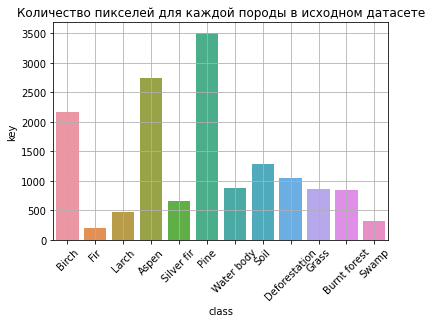

In [95]:
dict_normal_names={7: "Pine", 
        2:"Fir", 
        5:"Aspen",
        3:"Cedar",
        4:"Larch",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body'}
pixels_per_class = df.groupby('class', as_index=False).count()
pixels_per_class['class'] = pixels_per_class['class'].apply(lambda x: dict_normal_names[x])
sns.barplot(data=pixels_per_class, x='class', y='key')
plt.grid()
plt.title('Количество пикселей для каждой породы в исходном датасете')
plt.xticks(rotation=45)
plt.show()

In [97]:
df_score_group

,Model,Accuracy score,ROC AUC score,f1 score
0,KNeighborsClassifier,0.448190,0.671745,0.429184
1,DecisionTreeClassifier,0.409904,0.630309,0.411830
2,RandomForest,0.479401,0.790379,0.457559
3,ExtraTreesClassifier,0.446941,0.780236,0.440636
4,LogisticRegression,0.419476,0.751885,0.439622
5,SVC,0.383271,0.776798,0.398371
6,GradientBoostingClassifier,0.465668,0.728054,0.445258


In [98]:
scores_model = df_score_class_dict['RandomForest']
scores_model.index = pd.Series(scores_model.index).apply(lambda x: decodeClassesLevel1(x))
scores_model

RandomForest                                 
                precision    recall  f1-score      support
Birch            0.441423  0.308480  0.363167   684.000000
Fir              0.000000  0.000000  0.000000    72.000000
Larch            0.238636  0.141892  0.177966   148.000000
Aspen            0.476056  0.509804  0.492353   663.000000
Silver fir       0.512821  0.634921  0.567376   126.000000
Pine             0.522917  0.707042  0.601198   710.000000
accuracy         0.479401  0.479401  0.479401     0.479401
macro avg        0.365309  0.383690  0.367010  2403.000000
weighted avg     0.453085  0.479401  0.457559  2403.000000

In [84]:
scores_model = df_score_class_dict['RandomForest']
scores_model.index = pd.Series(scores_model.index).apply(lambda x: decodeClassesLevel1(x))
scores_model

RandomForest                                
                precision    recall  f1-score     support
Birch            0.431034  0.483092  0.455581  207.000000
Fir              0.000000  0.000000  0.000000   14.000000
Larch            0.026316  0.016393  0.020202   61.000000
Aspen            0.568627  0.402778  0.471545  288.000000
Silver fir       0.454545  0.200000  0.277778   75.000000
Pine             0.546318  0.787671  0.645161  292.000000
accuracy         0.493063  0.493063  0.493063    0.493063
macro avg        0.337807  0.314989  0.311711  937.000000
weighted avg     0.478346  0.493063  0.470184  937.000000

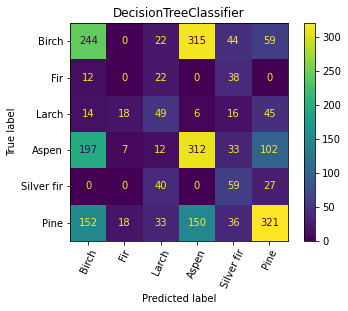

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
dict_normal_names={7: "Pine", 
        2:"Fir", 
        5:"Aspen",
        3:"Cedar",
        4:"Larch",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body'}

clf = base_classfiers[-6]
predictions = clf.predict(X_test)
names = [dict_normal_names[value] for value in clf.classes_]
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=names)
disp.plot()
plt.title(name_classfiers[-6])
plt.xticks(rotation=65)
plt.show()

## 3. Кластеризация

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3783 samples in 0.001s...
[t-SNE] Computed neighbors for 3783 samples in 0.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3783
[t-SNE] Computed conditional probabilities for sample 2000 / 3783
[t-SNE] Computed conditional probabilities for sample 3000 / 3783
[t-SNE] Computed conditional probabilities for sample 3783 / 3783
[t-SNE] Mean sigma: 0.043459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.820465
[t-SNE] KL divergence after 1000 iterations: 0.590038


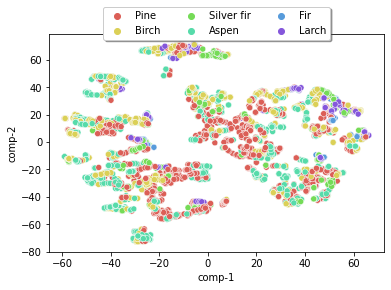

In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
df = pd.concat([bands.iloc[:, :-2], terrain], axis=1)
df = df.copy()
df[['aspect','slope','wetnessindex','sink']] = df[['aspect','slope','wetnessindex','sink']].astype(float)

forest = df["class"] < 8
df = df.loc[forest]

X = df.iloc[:, :-2]
z = tsne.fit_transform(X)

df_plot = pd.DataFrame(data=df.iloc[:, -1].values, columns=['y'])
# df_plot["y"] = df.iloc[:, :-1]
df_plot['y'] = df_plot['y'].apply(lambda x: dict_normal_names[x])
df_plot["comp-1"] = z[:,0]
df_plot["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_plot.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df_plot).set(title="Forest data T-SNE projection")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)
plt.show()

# END

## another exp

In [85]:
forest_gdf = gdf.loc[gdf['t_Class']<8]
X_train, X_test, y_train, y_test = train_test_split(forest_gdf, forest_gdf['class_name'], test_size=0.3)

train = df_resampled.loc[df_resampled['key'].isin(X_train['key'])]

test = df_resampled.loc[df_resampled['key'].isin(X_test['key'])]


X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

In [109]:
from imblearn.over_sampling import SMOTE

In [131]:
rus = SMOTE()
X_res, y_res = rus.fit_resample(df_resampled.iloc[:, :-1], df_resampled.iloc[:, -1].astype(int))
sub_df_resampled= pd.DataFrame(X_res, columns=df.columns[:-1])
sub_df_resampled.loc[:, 'class'] = y_res

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pl = Pipeline([('scaler', StandardScaler()),
               ('pca', PCA()),
               ('clf', GradientBoostingClassifier())])


X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

y_test=codeClasses(y_test)
y_train=codeClasses(y_train)
# cv = CrossValidatorWrapper(KFold())
gridsearch = GridSearchCV(pl, scoring='balanced_accuracy',
                    param_grid={
                      "scaler__with_std":[True,False],
                      "pca__n_components": [1, 2, 3]
                      }, n_jobs=8)

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', GradientBoostingClassifier())]),
             n_jobs=8,
             param_grid={'pca__n_components': [1, 2, 3],
                         'scaler__with_std': [True, False]},
             scoring='balanced_accuracy')

In [65]:
results = gridsearch.cv_results_

In [514]:
X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

y_test=codeClasses(y_test)
y_train=codeClasses(y_train)

In [2]:
seed = 7
models = []
models.append(('SVC', SVC(verbose=True)))
models.append(('RandomForest', RandomForestClassifier(verbose=1, n)))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RidgeClassifier', RidgeClassifier()))

results = []
names = []
# scoring = {"OA":"balanced_accuracy", "f1_macro":'f1_macro'}
scoring= 'f1_macro'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.savefig('../plots/models_comparison.png', dpi=150)
plt.show()


In [1]:
## two-metrics scoring
scoring = {"OA":"balanced_accuracy", "f1_macro":'f1_macro'}

param_grid = {
    "n_estimators": range(5, 100, 10),
    "max_leaf_nodes": range(2, 100, 10),
    "min_samples_split": range(2, 50, 5),
    "learning_rate": loguniform.rvs(0.01, 1, size=10),
}

gs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42, verbose=0),
    n_iter=100,
    param_distributions=param_grid,
    scoring=scoring,
    cv=5,
    refit="f1_macro",
    n_jobs=8,
    return_train_score=True,
    verbose=10
)
gs.fit(X_train, y_train)
results = gs.cv_results_

In [298]:
OA = results['mean_test_OA']
f1_macro = results['mean_test_f1_macro']

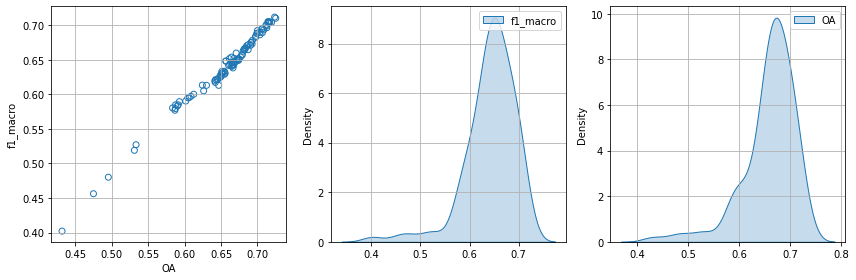

In [299]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
ax1.scatter(OA, f1_macro, edgecolors=sns.color_palette()[0], facecolors='none')
ax1.grid()
# ax1.set_ylim(0,1)
# ax1.set_xlim(0,10)
ax1.set_ylabel("f1_macro")
ax1.set_xlabel("OA")
# ax2.scatter(mape_normalized, r2_normalize)
sns.kdeplot(f1_macro, fill=True, label="f1_macro", ax=ax2)
ax2.grid()
ax2.legend()
sns.kdeplot(OA, fill=True, label="OA", ax=ax3)
ax3.grid()
ax3.legend()
# ax2.set_ylabel("$R^2$")
# ax2.set_xlabel("$MAPE$")
# plt.savefig('../plots/two_metrics_plots.png', dpi=300)

## 6. Color geotiff

In [146]:
fname = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer_2020.tiff'
with rio.open(fname) as src:
    bands_row= src.read()

In [149]:
shape_row = bands_row.shape

In [152]:
dates_images_2020 = ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]

def get_2020_cols():
    col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
    all_cols = []
    i = 0
    for date in sorted(dates_images_2020):
        for col in col_names:
            
            all_cols.append(date+'_'+col)
    return all_cols

cols_2020 = get_2020_cols()

x = bands_row[:-4, ...].reshape(len(cols_2020), bands_row.shape[1]*bands_row.shape[2])

In [177]:
for i in range(x.shape[1]//100000 + 1):
    select = x[:, i*100000:(i+1)*100000]
    if (i+1)*100000 > x.shape[1]:
        select = x[:, i*100000:x.shape[1]]
    break

In [184]:
df_indices_field = pd.DataFrame(select.T, columns=cols_2020)

In [185]:
def prepare_SVI(df:pd.DataFrame)->pd.DataFrame:
    for date in ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]:
        print(date)
        df = dataset.get_ndvi(df, date)
        df = dataset.generate_NDRE(df, date)
        df = dataset.evi(df, date)
        df = dataset.generate_MSAVI(df, date)

    return df
df_indices_field = prepare_SVI(df_indices_field)

2020-07-03
2020-07-05
2020-07-13
2020-08-04
2020-08-09
2020-08-12
2020-08-17


In [ ]:
dates_images_2020 = ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]

def get_2020_cols():
    col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
    all_cols = []
    i = 0
    for date in sorted(dates_images_2020):
        for col in col_names:
            
            all_cols.append(date+'_'+col)
    return all_cols

cols_2020 = get_2020_cols()


# shape = box(*gdf.total_bounds)
fname = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer_2020.tiff'
with rio.open(fname) as src:
    bands_row= src.read()
x = bands_row[:-4, ...].reshape(len(cols_2020), bands_row.shape[1]*bands_row.shape[2])


df_indices_field = pd.DataFrame(x.T[::100, :], columns=cols_2020)


def prepare_SVI(df:pd.DataFrame)->pd.DataFrame:
    for date in ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]:
        print(date)
        df = dataset.get_ndvi(df, date)
        df = dataset.generate_NDRE(df, date)
        df = dataset.evi(df, date)
        df = dataset.generate_MSAVI(df, date)

    return df

# slices =  
mean_X = np.ones(shape=(13, x.shape[1]))
for y in range(14):
    print(y)
    channels = []
    for i in range(len(dates_images_2020)):
        channels.append(y-1 + i * 13)
    mean_channel = x[channels, ...].mean(axis=0)
    mean_X[y] = mean_channel

## 2. EDA

In [3]:
# # Fill diagonal and upper half with NaNs
# corr = non_forest.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[::3, ::2]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))

In [353]:
corr_matrix = non_forest.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
non_forest.drop(to_drop, axis=1, inplace=True)

In [1]:
# # Fill diagonal and upper half with NaNs
# corr = non_forest.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[:, :]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))

## 3. Plotting


In [349]:

def plot_RGB_file(fname: str): 
    img = rio.open(fname)

    red = img.read(4)
    green = img.read(3)
    blue = img.read(2)

    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    return rgb_composite_bn

def plot_RGB_matrix(img)->None: 
    red = img[4, ...]
    green = img[3, ...]
    blue = img[2, ...]
    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    plt.imshow(rgb_composite_bn)

In [ ]:
path='/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/'
list_of_geotiff = [tiff for tiff in os.listdir(path) if 'tiff' in tiff]
mask = (df_indices_field['date'].dt.month>6) & (df_indices_field['date'].dt.month<9)
dates_images = df_indices_field.loc[mask, 'date'].unique()
dates_images = [str(image)[:10] for image in dates_images]

In [148]:
src = rio.open(path_to_tiff_file)

In [100]:
dataset = Dataset()
src = rio.open(dataset.path_to_tiff_file)
X = src.read()

In [20]:
s2 = rio.open("/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/2019-06-19.tiff")
s2.read(2).shape

(13, 3300, 2966)

In [153]:
def normalize(X):
    X = X/10000
    X = np.clip(X, 0, 0.3)
    return X

In [162]:
X = normalize(124)

In [220]:
for x in sorted(dates_images):
    print(x+'.tiff ', end='')

2019-07-01.tiff 2019-07-04.tiff 2019-08-03.tiff 2019-08-05.tiff 2019-08-08.tiff 2019-08-15.tiff 2019-08-30.tiff 2020-07-03.tiff 2020-07-05.tiff 2020-07-13.tiff 2020-08-04.tiff 2020-08-09.tiff 2020-08-12.tiff 2020-08-17.tiff 

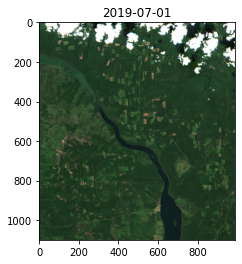

In [147]:
for tiff_file in sorted(dates_images):
    path_to_tiff_file = os.path.join(path, tiff_file+'.tiff')
    print()
    rgb_composite_bn = plot_RGB_file(path_to_tiff_file)
    plt.imshow(rgb_composite_bn[::3, ::3, :])
    plt.title(tiff_file.split('.')[0])
    plt.show()
    break

In [114]:
shape = gdf.iloc[0,-2]

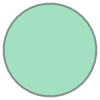

In [115]:
shape

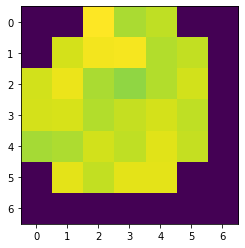

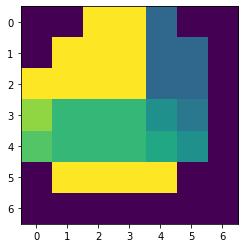

In [136]:


shape = gdf.iloc[-2,-2]


with rio.open(dataset.path_to_tiff_file) as src:
    out_image, out_transform = crop_mask(src, [shape], crop=True, nodata=0) # SUPER KEK - [shape] works, shape - doesn't 
    out_meta = src.meta 
#     x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
# _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
# plt.imshow(out_image[3,...])

plt.imshow(out_image[1,...])
plt.show()

plt.imshow(out_image[-4,...])
plt.show()

In [137]:
s2 = out_image[2,...]

t1 = out_image[-2,...]

sub_m = np.where(s2>0, t1, -1)

In [138]:
s2.shape

(7, 7)

In [145]:
sub_m = np.where(s2>0, t1, -1)

array([[-1, -1,  0,  0,  8, -1, -1],
       [-1,  0,  0,  0,  8,  8, -1],
       [ 8,  0,  0,  0,  8,  8, -1],
       [ 8,  8,  8,  8,  8,  8, -1],
       [ 8,  8,  8,  8,  8,  9, -1],
       [-1,  0,  0,  0,  0, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1]], dtype=int32)

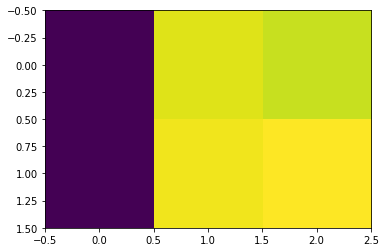

In [119]:
plt.imshow(out_image[1,...])

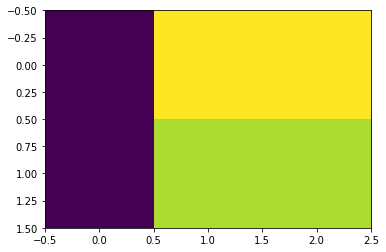

In [123]:
plt.imshow(out_image[-2,...])

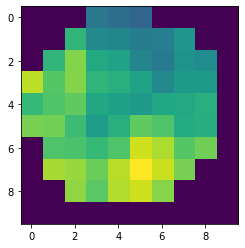

In [73]:
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
plt.imshow(out_image[3,...])

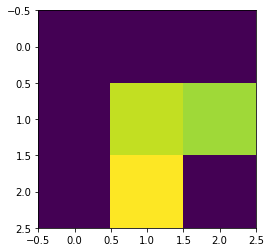

In [75]:
shape = gdf_8m.iloc[0,-1]
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df

plt.imshow(out_image[3,...])

In [16]:
gdf_8m.crs

<Derived Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## * Clusters

In [187]:
from sklearn.cluster import DBSCAN

In [189]:
fnames = {"invent_plots":"../shape_data/dataset_plots.geojson"}
gdf = gpd.read_file(fnames['invent_plots'])
gdf.loc[:, 'key'] = gdf.index
gdf=procces_gdf(gdf)
dataset = Dataset(tiff_fname=None, scale=1)
bands, terrain = dataset.prepare_forest_classes_dataset(gdf=gdf)
col_2020 = [col for col in bands.columns if '2019' not in col]
df = pd.concat([bands[col_2020[:-2]], terrain], axis=1)
df = df.copy()
df[['aspect','slope','wetnessindex','sink']] = df[['aspect','slope','wetnessindex','sink']].astype(float)
forest = df["class"] < 20
df_resampled = df.loc[forest]
_X = df_resampled.iloc[:, :-2]
scaled = StandardScaler().fit_transform(_X)
df_resampled.iloc[:, :-2] = scaled

8.974945806042294
Start bands . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Start terrain . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [204]:
df= df_resampled.loc[df_resampled['class'] < 8]

In [205]:
X = df.iloc[:, :-2].values
labels_true = df['class'].values

In [207]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Estimated number of noise points: 1552
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


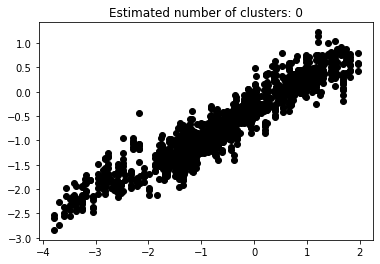

In [208]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [209]:
from sklearn.manifold import TSNE

In [285]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1552 samples in 0.002s...
[t-SNE] Computed neighbors for 1552 samples in 0.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1552
[t-SNE] Computed conditional probabilities for sample 1552 / 1552
[t-SNE] Mean sigma: 1.522654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.012894
[t-SNE] KL divergence after 1000 iterations: 0.420003


[Text(0.5, 1.0, 'Iris data T-SNE projection')]

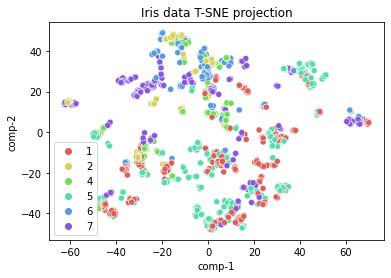

In [286]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)
df = pd.DataFrame()
df["y"] = labels_true
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="Iris data T-SNE projection")

In [284]:
df_resampled

,2020-07-03_B01,2020-07-03_B02,2020-07-03_B03,2020-07-03_B04,2020-07-03_B05,2020-07-03_B06,2020-07-03_B07,2020-07-03_B08,2020-07-03_B8A,2020-07-03_B09,...,2020-08-17_NDVI,2020-08-17_EVI,2020-08-17_MSAVI,2020-08-17_NDRE,aspect,slope,wetnessindex,sink,key,class
1,1.792429,1.348706,0.330713,0.312257,-0.095310,-0.253746,-0.268301,-0.281320,-0.242449,0.571983,...,0.371992,-0.074120,-0.127335,0.229506,1.367919,0.953838,0.910102,0.923583,0,7
2,1.792429,1.016141,0.385859,0.126729,-0.201537,0.000807,0.201008,-0.243810,0.060850,0.571983,...,0.329715,-0.104955,-0.158971,0.439258,1.408838,1.133018,0.910102,0.975758,0,7
3,1.792429,1.282193,0.291323,0.103538,-0.201537,0.000807,0.201008,-0.308327,0.060850,0.571983,...,0.282231,-0.190107,-0.247549,0.384072,1.436118,1.312197,0.910102,0.975758,0,7
4,1.792429,1.109259,0.165276,0.219493,-0.181865,0.016499,0.127631,-0.153785,0.071360,0.571983,...,0.371786,-0.007890,-0.056854,0.825016,1.463398,1.670557,0.910102,1.030659,0,7
5,1.792429,1.082654,-0.023796,0.003044,-0.181865,0.016499,0.127631,-0.486875,0.071360,0.571983,...,0.409103,-0.239694,-0.303155,0.611763,1.613438,1.670557,0.910102,1.030659,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,-0.009217,-0.141186,0.236177,0.057156,0.018786,-0.288617,-0.398239,-0.416356,-0.365571,-0.310101,...,-0.300856,-0.863239,-0.918285,-0.964674,-2.683160,0.057938,1.164150,1.083686,287,15
5,-0.009217,0.257893,0.385859,0.374099,0.018786,-0.288617,-0.398239,-0.272317,-0.365571,-0.310101,...,-0.323759,-0.735622,-0.788625,-0.749044,-1.455560,0.057938,1.164150,0.943686,287,15
6,-0.009217,-0.034765,0.015594,-0.035608,-0.020558,-0.332204,-0.538879,-0.378846,-0.421125,-0.310101,...,-0.290550,-0.672576,-0.725979,-0.790179,0.385839,-0.300422,-0.868234,1.083686,287,15
7,-0.009217,-0.300817,0.165276,-0.020147,0.065998,-0.271181,-0.523592,-0.512382,-0.364069,-0.310101,...,-0.198935,-0.677727,-0.734866,-0.824091,-2.069360,0.237118,1.164150,1.083686,287,15
